<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="150" height="90" />

</p>


## A Machine Learning Approach for Decline Curve Analysis in Gas Production for the Haynesville Shale Gas Formation using Isotonic Regression with Python.

### Julio Cesar Villarroel S.
####  Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
##### [LinkedIn](https://www.linkedin.com/in/juliovillarroel/) | [Twitter](https://twitter.com/julvillarroel) |[GitHub](https://github.com/julijefe) 

### Subsurface Machine Learning Course, The University of Texas at Austin

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Student's Supervisor: Prof. Larry W. Lake, Shahid and Sharon Ullah Endowed Chair in Petroleum and Geosystems Engineering, The UniversIty of Texas at Austin

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin


### Executive Summary

Decline Curve Analysis is well covered in the Petroleum Engineering literature. However, there are challenges encountered in unconventionals such as the fact that traditional models do not capture the behavior on ultra low permeability formations, alongside the bias on part of the evaluator(s). To mitigate bias, Machine Learning approaches could be used as reliable technology for assesment of gas prediction (Fulford, Bowie, 2016).   

This workflow will use isotonic peacewise regression in order to buil a gas production model (rate vs time) using production diagnostic plots, and will try to capture the "external flow" or "tipping flow" time (A concept still under research at the University of Texas at Austin), with an analysys on the slopes from the isotonic regression. for a random well in the Haynesville formation. The Haynesville is an unconventional shale gas formation located in West Louisiana and West Texas. 

Our recommendation is to use such approach to get an estimate of the time for tipping flow, and use  isotonic regression to buuild type curves for decline curve analysis in the Haynesville. 

### Import Required Packages

Produution data is public, and is monthly volumes in a range of 8-10 years in months. Condition: data should be un interrupted (not signs of re-fracks, or large interruptions on flow). 

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python      
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import seaborn as sns                     # advanced statistical methods and plots
from scipy import stats                   # summary statistics
import math                               # trig etc.
import scipy.signal as signal             # kernel for moving window calculation
import random
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.metrics import explained_variance_score        #to assess variance 
import scipy.stats as st                                    # statistical methods

# Set the working directory 
I think this is vey useful so that the data and work are in a place safe in your computer. This will also avoid to have hard code the address each time. 

In [4]:
os.chdir("c:/PGE383")                     # set the working directory

## Load the Data
This dataset is from a well with undisturbed production data, from the Haynesville. It has monthly volumes in Mscf and the time in months, plus some other columns not much relevant for this workflow. This is public production data. We will work in the following features:

* **Month_Number** - is the month correlative number for the provided production data
* **DI_Gas** - Gas monthly volumes in Mcf (a Thousand Cubic feet). the DI word means Drilling Info, and is from the database that uses public production data.  
* **API10** - Is the name of the well. 
* **Days** - Is the number of days in that given month, is useful for gas rate calculations


The data set is available at #The dataset is available at https://github.com/julijefe/UT-Austin-Project/blob/6d8b8a9e0d0b05111338814b333c96c05759e237/Haynesville_Well_Production_Data.xlsm . As of year 2021, I am new to GitHub (this is a ongoing working project). You are supposed to be able to download the dataset easily from this cloud. However, if there are challenges, do not hesitate to shoot me an email at: julio.villarroel@utexas.edu, I will be happy to collaborate!. 

Once downloaded, save it in the working directory. 

In [19]:
df = pd.read_excel('Haynesville_Well_Production_Data.xlsm')

Let's visualize the data and check if we uploaded correctly

In [20]:
df.head()

,Date,Month_Number,DI_Oil,DI_Gas,isForecasted,API10,Days
0,2011-01-01,1,0.06,14073,Well,1701524669,31
1,2011-02-01,2,0.05,215649,Well,1701524669,28
2,2011-03-01,3,0.04,238324,Well,1701524669,31
3,2011-04-01,4,0.04,248291,Well,1701524669,30
4,2011-05-01,5,0.03,250343,Well,1701524669,31


## 1. Prepare Diagnostic Pots 
In simple words, reservoir engineers like to "Transform: the data in such a way that when plotting them, one can find patterns, linear relationships, or, as you will see later on, you will find phenomenon now easily found in normal plots. That is the power of diagnostic plots. I prepared my own for the Haynesville. 

In [21]:
df["Gas_rate_Mscfd"]=df['DI_Gas']/df["Days"]  #calculate a column of gas rates
df['Cum_gas']=df['DI_Gas'].cumsum() #prepare a column of culumative volumes

In [22]:
#Checking for Stationarity: we will use the simple derivative in a for loop to calculate the
#differences dQ and dt, so that we can use them in a diagnostic 
index = 0
df['dQ_MMcf'] = 0
for i in df['Cum_gas']: 
    if index < len(df['Cum_gas'])-1:
        df['dQ_MMcf'].values[index] = df['Cum_gas'].values[index+1]/1000 - df['Cum_gas'].values[index]/1000
        index +=1

        df.head()

The function to be used for plotting is the change of cumulative gas with respect to time, normalized by rate. Is not published yet in SPE, and I came up with this when I was studying logistic growth models for DCA. Basically I grabbed the idea of plotting this from the classic loss-ratio definition in classic Hyperbolic decline curve analysys which is (1/q*dq/dt), q being the rate. this time, we will big Q, for the the cumulative data.Hang on!, is a very useful plot. 

Another column that will be created is the one proposed by Duong (2012), that describes the plot of rate divided by cumulative and plotted against the log of time, to spot linear relationships on the data easy to extrapolate. 

In [24]:
df['q/Q']=df['Gas_rate_Mscfd']/df["Cum_gas"]       #Gas Rates column in Mscfd       
df['1/Q*dQ/dt']= df['dQ_MMcf']/(max(df['Cum_gas'])/1000)   #change of the cumulative with respect to time, normalized by cumulative data. 

In [13]:
df.head()   #we want to check if its performing correctly. 

,Date,Month_Number,DI_Oil,DI_Gas,isForecasted,API10,Days,Gas_rate_Mscfd,Cum_gas,dQ_MMcf,q/Q,1/Q*dQ/dt
0,2011-01-01,1,0.06,14073,Well,1701524669,31,453.967742,14073,215,0.032258,0.029242
1,2011-02-01,2,0.05,215649,Well,1701524669,28,7701.750000,229722,238,0.033526,0.032370
2,2011-03-01,3,0.04,238324,Well,1701524669,31,7687.870968,468046,248,0.016425,0.033730
3,2011-04-01,4,0.04,248291,Well,1701524669,30,8276.366667,716337,250,0.011554,0.034002
4,2011-05-01,5,0.03,250343,Well,1701524669,31,8075.580645,966680,240,0.008354,0.032642


Looks good. Let's find the boundaries of each of the variables calculated and be ready to plot in the diagnostic plots section. Be aware of the units being used. For other datasets, check the units and the names of the columns, the code should work just fine after this. 

Time to plot the data: I used maplotlib and these plots are ready to show the data in the variables that we just created above. 
Note: if the limits are to be changed, just make sure you go to the correspondant line of code under the correspondant plot. 

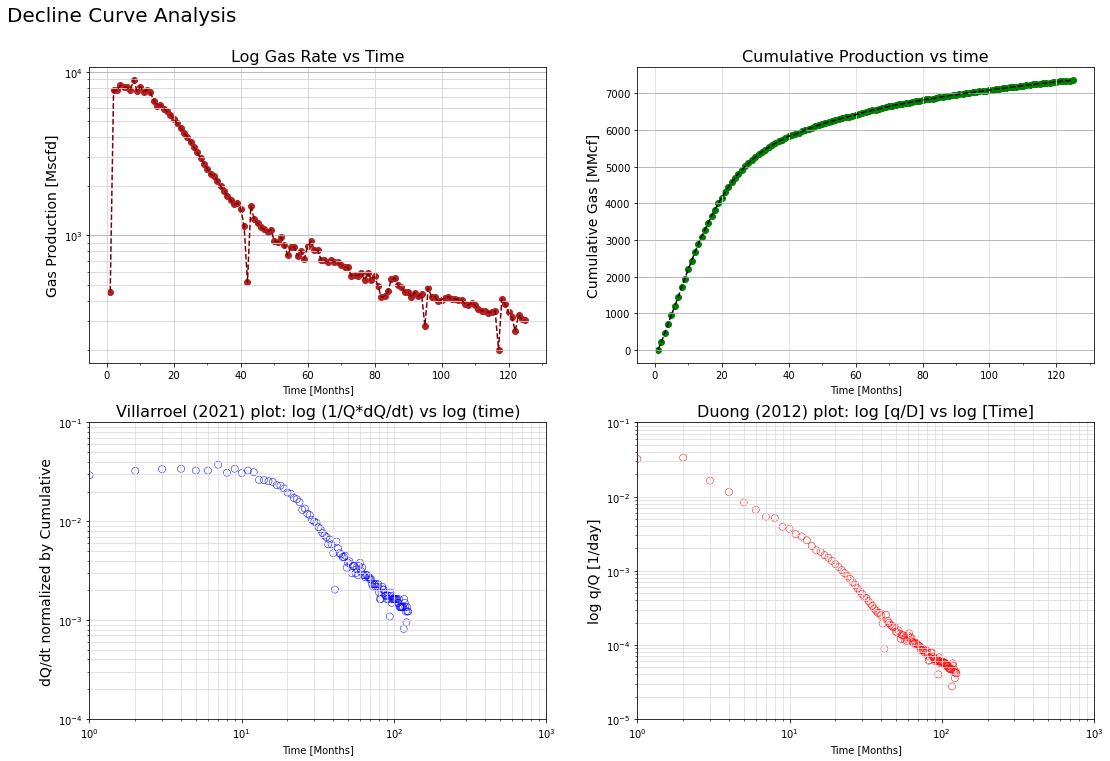

In [16]:
#colors     
#https://matplotlib.org/2.0.2/examples/color/named_colors.html
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#DEFINE your variables to plot, x is usually time
x=df['Month_Number']   
y1=df['Gas_rate_Mscfd']
y2=df['Cum_gas']/1000
y3=df['1/Q*dQ/dt']
y4=df['q/Q']

#GENERALIZATION OF THE PLOTS USING SUBPLOTS FUNCTION 

figure, axis = plt.subplots(2,2, figsize=(18,12))
figure.suptitle("Decline Curve Analysis", x=0.15, y=0.95, fontsize=20 )

#GEOMETRY OF THE PLOTS: this code works when you want different sizes

# plot1= plt.subplot2grid((2,2),(0,0), colspan=1)
# plot2= plt.subplot2grid((2,2),(0,1), colspan=1)
# plot3= plt.subplot2grid((2,2),(1,0), colspan=1)
# plot4= plt.subplot2grid((2,2),(1,1), colspan=1)

#PLOT1 : upper left
title1 = 'Log Gas Rate vs Time'
xlab1 = 'Time [Months]'
ylab1 = 'Gas Production [Mscfd]'
axis[0,0].set_yscale("log")
axis[0,0].grid(True, axis='x', which='major', color='lightgrey')
#axis[0,0].grid(False, axis='x', which='minor', color='darkgray')
axis[0,0].grid(True, axis='y', which='major', color='darkgrey')
axis[0,0].grid(True, axis='y', which='minor', color='lightgrey')
axis[0,0].xaxis.set_minor_locator(MultipleLocator(10))
# axis[0,0].set_ylim(100,1e6)
axis[0,0].scatter(x,y1,color='firebrick')
axis[0,0].plot(x,y1,'maroon',linestyle='dashed')
axis[0,0].set_title(title1, fontsize=16)  
axis[0,0].set_xlabel(xlab1)
axis[0,0].set_ylabel(ylab1,  fontsize=14)

#PLOT2: upper right
title2 ='Cumulative Production vs time'
xlab2 = 'Time [Months]'
ylab2 = 'Cumulative Gas [MMcf]'
#axis[0,1].set_yscale("log")
axis[0,1].grid(True, axis='x', which='major', color='gainsboro')
#axis[0,0].grid(False, axis='x', which='minor', color='darkgray')
axis[0,1].grid(True, axis='y', which='major', color='darkgrey')
axis[0,1].grid(True, axis='y', which='minor', color='gainsboro')
# axis[0,0].set_ylim(100,1e6)
axis[0,1].scatter(x,y2,color='green')
axis[0,1].plot(x,y2,'black',linestyle='dashed')
axis[0,1].xaxis.set_minor_locator(MultipleLocator(10))    
axis[0,1].set_title(title2, fontsize=16)  
axis[0,1].set_xlabel(xlab2)
axis[0,1].set_ylabel(ylab2, fontsize=14)

#PLOT3: down left: JulioVillarroel Plot for the analysis of change of cumulative 
#volumes with respect to time, normalized by cumulative data
title3 = 'Villarroel (2021) plot: log (1/Q*dQ/dt) vs log (time)'
xlab3 = 'Time [Months]'
ylab3 = 'dQ/dt normalized by Cumulative'
axis[1,0].set_yscale("log")
axis[1,0].set_xscale("log")
axis[1,0].grid(True, which='both', axis='both', color='gainsboro')
axis[1,0].set_ylim(0.0001,0.1)
axis[1,0].set_xlim(1,1000)
axis[1,0].scatter(x,y3,facecolors='none', edgecolors='b', s=50, linewidths=.5)
axis[1,0].set_title(title3, fontsize=16)  
axis[1,0].set_xlabel(xlab3)
axis[1,0].set_ylabel(ylab3, fontsize=14)

#PLOT4: down right
title4 = 'Duong (2012) plot: log [q/D] vs log [Time]'
xlab4 = 'Time [Months]'
ylab4 = 'log q/Q [1/day]'
title3 = 'log (1/Q*dQ/dt) vs log (time)'
xlab3 = 'Time [Months]'
ylab3 = 'dQ/dt normalized by Cumulative'
axis[1,1].set_yscale("log")
axis[1,1].set_xscale("log")
axis[1,1].grid(True, which='both', axis='both', color='gainsboro')
axis[1,1].set_ylim(0.00001,0.1)
axis[1,1].set_xlim(1,1000)
axis[1,1].scatter(x,y4,facecolors='none', edgecolors='r', s=50, linewidths=.5)
axis[1,1].set_title(title4, fontsize=16)  
axis[1,1].set_xlabel(xlab4)
axis[1,1].set_ylabel(ylab4, fontsize=14)
plt.show()

# 2. Machine Learning

Now we are going to use Machine Learning to perform isotonic regression, by training and testing of the data, and obtain a model that could describe the different flow regimes of the model, where is not possible to do in the traditional hyperbolic curve.  

### Isotonic Regression Modeling

Allows us to perform peasewise regression in a time series relationship incorporating physics about the system. For instance, since this is a decline curve, the production should not ramp up, unless there is a clear sign of increasing rates, such as a clear sign of refrac. Let's perform the isotonic regression and build a model for production prediction in the Haynesville. 

#### Isotonic Regression
The following description, is from Dr. Michael Pyrcz, in 
Isotonic regression for prediction.  Here are some key aspects of linear regression:

**Stepwise Linear Parametric Model**

* the fit model is a piece-wise linear model at specific predictor feature isotonic constraints / thresholds under the constraint that $x_1 \ge ... \ge x_k$ where the resulting model must be monotonically increasing, $\hat{f}(x_1) \ge ... \ge \hat{f}(x_k)$.

* the loss function is: 

\begin{equation}
min \sum_{i=1}^{n} w_i (y_i - \hat{f}(x)_i)^2
\end{equation}

Subject to the constraint that:

\begin{equation}
\hat{f}(x_1) \ge ... \ge \hat{f}(x_n)
\end{equation}

**Assumptions**
* **Model Parameters** - parameterized by response at each isotonic constraint / threshold
* **Monotonic Decreasing** - may not have a positive slope 
* **Piece-wise Linear Model** - assumes linear interpolation between each point

Source: Michael Pyrcz, PhD. Workflow and Course notes for Isotonic regression. 2019. University of Texas at Austin.

### 2.1 Test and Train Split
Let's separate the data into test and train and visualize it.We will perform the modeling  in the diagnostic plots of the dq/dt normalized by Q.

In [26]:
my_data_subset = df.iloc[:,[1,10,11]]                    # extract just por, brittle and prod with 100 samples

In [27]:
my_data_subset.head()       #checking out if we extracted the data that we need, 

,Month_Number,q/Q,1/Q*dQ/dt
0,1,0.032258,0.029242
1,2,0.033526,0.032370
2,3,0.016425,0.033730
3,4,0.011554,0.034002
4,5,0.008354,0.032642


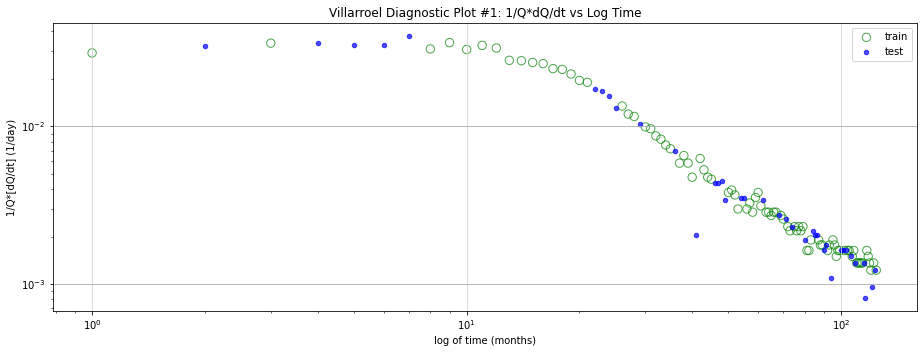

In [28]:
X_train, X_test, y_train, y_test = train_test_split(my_data_subset.iloc[:,0], my_data_subset.iloc[:,2], test_size=0.30, random_state=73073)
plt.subplot(111)
plt.scatter(X_train, y_train,  facecolors='none', edgecolors='green', s = 70, alpha = 0.7, label='train')
plt.scatter(X_test, y_test,  color='blue', s = 20, alpha = 0.7, label='test')
plt.title('Villarroel Diagnostic Plot #1: 1/Q*dQ/dt vs Log Time'); plt.ylabel('1/Q*[dQ/dt] (1/day)'); plt.xlabel('log of time (months)')
#plt.xlim(0,4e-2); plt.ylim(0.00001,0.04)
plt.yscale("log")
plt.xscale("log")
plt.grid(True, axis='x', which='major', color='lightgrey')
#axis[0,0].grid(False, axis='x', which='minor', color='darkgray')
plt.grid(True, axis='y', which='major', color='darkgrey')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

The data, in both diagnostic (Villarroel or Duong) plots is mostly monotonic decreasing with little noise. The training and test split looks good as well. Let's try to establish the isotonic constants, this time, the X-axis will be plot in cartesian scale (not log-log scale) so that the isotonic lines will look equal in distance, and prove to our selves that we are on the right path. 

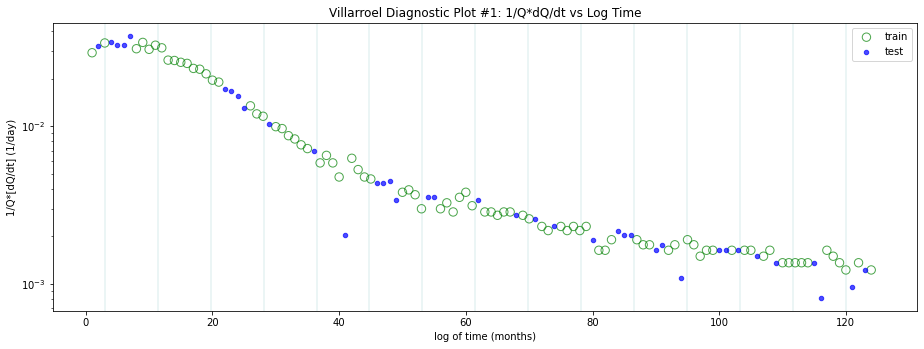

In [30]:
X_predict = np.linspace(3,120,num=15)
plt.subplot(111)
plt.scatter(X_train, y_train,  facecolors='none', edgecolors='green', s = 70, alpha = 0.7, label='train')
plt.scatter(X_test, y_test,  color='blue', s = 20, alpha = 0.7, label='test')
for threshold in X_predict:
    plt.axvline(threshold, color='teal', alpha = 0.1)
plt.title('Villarroel Diagnostic Plot #1: 1/Q*dQ/dt vs Log Time'); plt.ylabel('1/Q*[dQ/dt] (1/day)'); plt.xlabel('log of time (months)')
plt.yscale("log")
#plt.xscale("log")
#plt.xlim(0,100)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

If we plot in log scale, of course the isotonic lines will not be equally distanced. Scale is an important thing.

### 2.2. Fit the Model and Assesing the Slopes for External flow regime (flow beyond the tips).
Let's fit the model with these isotonic constraints / thresholds.

In [37]:
iso_reg = IsotonicRegression(increasing=False, out_of_bounds='clip').fit(X_train, y_train)
y_predict = iso_reg.predict(X_predict)

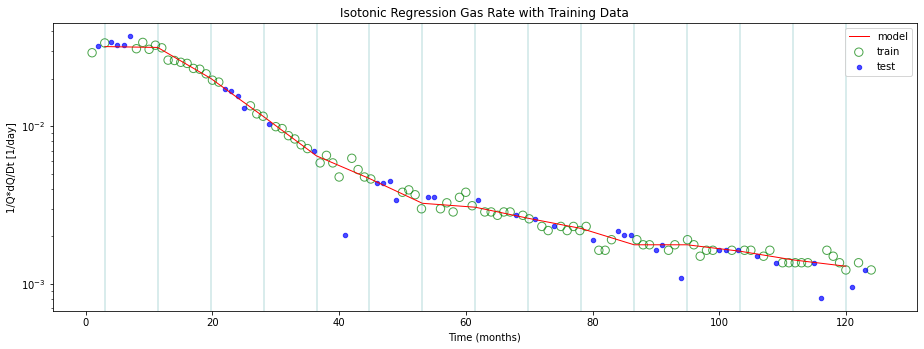

In [38]:
# Plot model fit
plt.subplot(111)
plt.scatter(X_train, y_train,  facecolors='none', edgecolors='green', s = 70, alpha = 0.7, label='train')
plt.scatter(X_test, y_test,  color='blue', s = 20, alpha = 0.7, label='test')
plt.plot(X_predict,y_predict, color='red', linewidth=1, label='model')
for threshold in X_predict:
    plt.axvline(threshold, color='teal', alpha = 0.2)
plt.title('Isotonic Regression Gas Rate with Training Data'); plt.ylabel('1/Q*dQ/Dt [1/day]'); plt.xlabel('Time (months)')
#plt.xlim(0,100)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.yscale("log")
#plt.xscale("log")
plt.legend()
plt.show()

This loks very good. If we spot the slope in the region within 50-60 months there is a change in the slope. Basically it levels off as zero slope, and then the second regime kicks in (flow beyond the tips). It is important to mention to use the **first change in slope**, because the second one is due a tighter region of the data in the log space. 
This new regime in unconventional is still under research (my research, under the supervision of Dr. Larry Lake, UT Austin), however isotonic regression makes us predict when this "change of slope" happens. That is the initial of external flow.

Expert tip: for the Haynesville, is good to stablish a space of 5 months, in the linspace function, this was achieved by stablishng the num=30.


In [73]:
def slopee(x1,y1):
    x = []
    for i in range(0,len(y1)-1):
        print(i)
        sl = (np.log(y1[i+1])- np.log(y1[i])) / (x1[i+1] - x1[i])
        x.append(sl)
    return x

Now we can appreciate one of the gifts of isotonic regression. We will use the slopes on each isotone, to find which are the the least negative ones. In the code above I observed the differences in these slopes, and applied their aboslute value so that we could appreciate the magnitude of them. 

### Brief comment on External or Flow Beyond the Tips: 
* The very first falt slope (or least negative) corresponds to the Build Up period, in which the well is in clean up.
* The second "least negative" slope, should occur around 50-65 months. This shows the depleted fractured zone (stimulated rock volume - srv) being "fed" by the original matrix into the external SRV. Is an awesome discovery because, with this data set, you can see something that has not been seen before in the last 10 years of data, due to the fact that these permeabilities are so small that people guessed it would theoretically take many years to see this. 

The physycs-based theory behind this, is currently under research, with the supervision of Dr. Larry Lake, David DiCarlo, Professors from the Petroleum and Geosystems Engineering at the University of Texas, and Prof. Michael Marder, from the Physics Department at UT Austin. 
                                                                                                                                            

In [75]:
diff=[]
test1=test.copy()
test1=np.abs(test1)
for i in range(0,len(test1)-1):
    #print("slope %d"%(i+1) , test[i], "at" ,X_predict[i])
    dslope = test1[i+1]-test1[i]
    diff.append(dslope)
print ("Analyze the differences in slopes:")
diff = np.abs(diff)
index_max = np.argmax(diff[2:])
index_max =index_max+4

for i in range(0,len(test1)-1):
    print("slope %d-slope %d"%(i+2,i+1) ,":",diff[i]*1000, "difference between (%d-%d) and (%d-%d) giving the external flow of time %d months"%(X_predict[i+2],X_predict[i+1],X_predict[i+1],X_predict[i],X_predict[i+1]))

print(">>>the time, in MONTHS, at which external flow happens is at " , X_predict[index_max-1])

Analyze the differences in slopes:
slope 2-slope 1 : 52.41925827567476 difference between (19-11) and (11-3) giving the external flow of time 11 months
slope 3-slope 2 : 13.025973410763433 difference between (28-19) and (19-11) giving the external flow of time 19 months
slope 4-slope 3 : 1.7048866863305367 difference between (36-28) and (28-19) giving the external flow of time 28 months
slope 5-slope 4 : 29.049918754962974 difference between (44-36) and (36-28) giving the external flow of time 36 months
slope 6-slope 5 : 3.6458223557893077 difference between (53-44) and (44-36) giving the external flow of time 44 months
slope 7-slope 6 : 36.37466298455188 difference between (61-53) and (53-44) giving the external flow of time 53 months
slope 8-slope 7 : 12.446335819710791 difference between (69-61) and (61-53) giving the external flow of time 61 months
slope 9-slope 8 : 1.557516551794643 difference between (78-69) and (69-61) giving the external flow of time 69 months
slope 10-slope 9 

#### 2.3 Make Predictions and Check the Model Goodness

Now let's make predictions at the testing data locations and check the model goodness

* let's use the variance explained

We will plot the estimates for the training data as 'predicted test'

* note the iso_reg.transform() function does not seem to work properly

* we will just use a linear interpolation function from numpy to make estimates of the response feature with the model at new predictor feature values

The follwoing code block is from Professor Michael Pyrcz (@Geostatsguy), SubsurfaceDataAnalytics_IsotonicRegression.ipynb []GeostatsGuy GitHub] (https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_IsotonicRegression.ipynb) 

Variance Explained = 0.988


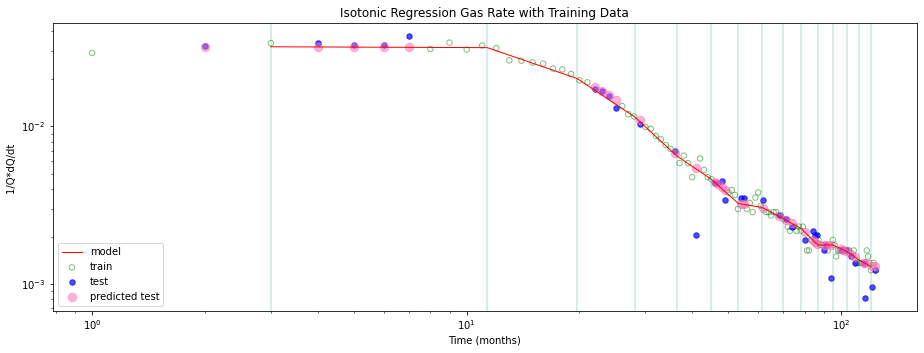

In [76]:
# The transform function should calculate the result for new observations, but doesn't seem to work
# let's just use piece-wise linear interpolation from NumPy.
#y_predict_test = iso_reg.transform(X_test)
y_predict_test = np.interp(X_test, X_predict, y_predict, left=None, right=None, period=None)
r2 = explained_variance_score(y_test,y_predict_test)
print('Variance Explained = ' + str(round(r2,3)))

# Plot test predictions
plt.subplot(111)
plt.scatter(X_train, y_train,   facecolors='none', edgecolors='green', s = 30, alpha = 0.5, label='train')
plt.scatter(X_test, y_test,  color='blue', s = 30, alpha = 0.7, label='test')
plt.scatter(X_test, y_predict_test,  color='hotpink', s = 70, alpha = 0.5, label='predicted test')
plt.plot(X_predict,y_predict, color='red', linewidth=1, label='model')
for threshold in X_predict:
    plt.axvline(threshold, color='teal', alpha = 0.2)
plt.title('Isotonic Regression Gas Rate with Training Data'); plt.xlabel('Time (months)'); plt.ylabel('1/Q*dQ/dt ')
plt.yscale("log")
plt.xscale("log")
#plt.xlim(0,200)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

### 2.4 Hyperparameter Tuning 
Tecnhically the code below enable us to obtain the ideal number for isotonic lines and evenly spaced samples for regression. Use the code below if the goal is to find the optimum regression for spacing. However this will not always lead to the slopes calculation optimum to "see" external flow. 

I found (expertise knowledge here), that is better to have data spaced every 6 months to be able to "spot" tipping flow. For this exercise, we used the linspace function hyperparameter (num) to be in num=20.

In [ ]:
isotonic_constraint_list = np.linspace(2,3,30)
r2 = []

for k in isotonic_constraint_list:
    X_predict = np.linspace(3,97,k)
    iso_reg = IsotonicRegression(increasing=False).fit(X_train, y_train)
    y_predict = iso_reg.predict(X_predict)
    y_predict_test = np.interp(X_test, X_predict, y_predict, left=None, right=None, period=None)
    r2.append(explained_variance_score(y_test,y_predict_test))

plt.subplot(111)
plt.plot(isotonic_constraint_list, r2, color='red', linewidth=1, label='model')
plt.title('Isotonic Regression Tuning Number of Isotonic Constraints'); plt.xlabel('Number of Isotonic Constraints'); plt.ylabel('Variance Explained in Testing')
#plt.xlim(0,40); plt.ylim(0,0.6)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)


# Results / Comments

Isotonic regression is a way to approach Decline Curve Analysis in unconventional formation where the the hyperbolic decline does not capture the entirety of the data. Also, we were able to show that is possible to spot "external" or tippin flow (still under research) by examining the slopes provided by isotonic regression.

Now the model for gas prediction will look a lot more smoother in cartesian plot (as it should be)


Variance Explained = 0.988


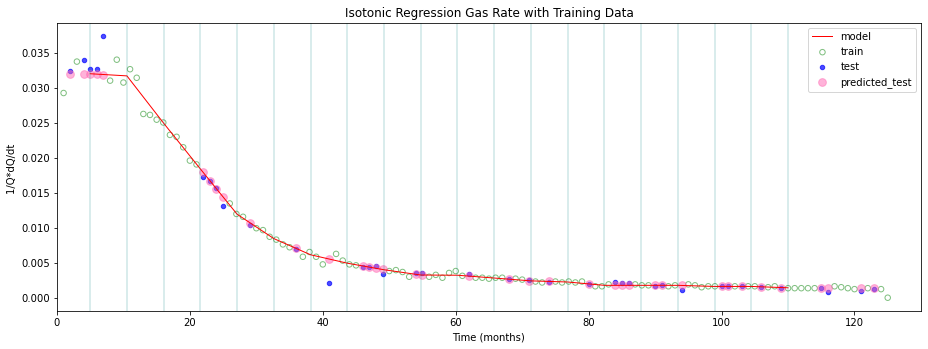

In [119]:
# Let's try varying the number of isotonic constraints, thresholds
number_isotonic_constraints = 20
X_predict = np.linspace(5,110,number_isotonic_constraints)
iso_reg = IsotonicRegression(increasing=False).fit(X_train, y_train)
y_predict = iso_reg.predict(X_predict)

# Make predictions at testing data locations and calculate the model goodness
y_predict_test = np.interp(X_test, X_predict, y_predict, left=None, right=None, period=None)
r2 = explained_variance_score(y_test,y_predict_test)
print('Variance Explained = ' + str(round(r2,3)))

# Plot test predictions
plt.subplot(111)
plt.scatter(X_train, y_train,   facecolors='none', edgecolors='green', s = 30, alpha = 0.5, label='train')
plt.scatter(X_test, y_test,  color='blue', s = 20, alpha = 0.7, label='test')
plt.scatter(X_test, y_predict_test,  color='hotpink', s = 60, alpha = 0.5, label='predicted_test')
plt.plot(X_predict,y_predict, color='red', linewidth=1, label='model')
for threshold in X_predict:
    plt.axvline(threshold, color='teal', alpha = 0.2)
plt.title('Isotonic Regression Gas Rate with Training Data'); plt.xlabel('Time (months)'); plt.ylabel('1/Q*dQ/dt ')
plt.xlim(0,130)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

####  Did you like this? 

Howdy!. I am a Reservoir Engineer with 8 years of experience in the exploration and development of conventional reservoirs and recently studied more the unconventionals. I’m pursuing a Graduate Degree at The University of Texas at Austin with research and classes focused on Advanced Reservoir Engineering under the supervision of Dr. Larry Lake, considered the World’s expert in this field.

Skills:
• Reserves evaluation and production forecasts.
• Prospect Field Appraisals.
• Big Data Analysis (Spotfire®).
• Pressure Transient Analysis (PTA) & Production Analysis (RTA).
• Asset Production Modeling (GAP®).
• Wellbore flow performance: Nodal analysis & artificial lift design.
• Supervised more than 200 field operations including well testing, slick-line, wireline logging, coiled-tubing, and well stimulation.

Tools skill set:
Python: Spyder/Jupyter Notebooks | IPM Petroleum Experts®: GAP®, MBal, Prosper, PVTp®| Kappa: Citrine®, Sapphir®, Topaze® | PanSystem®| Spotfire® (Big Data Analysis) | Drilling Info® | OFM® | PVT Sim®.

I am confident I have the skills, the network, and experience necessary to add value to your business. I graduate in 2022 and looking for opportunities as a reservoir engineer. Looking forward to hear from you soon.  

I can be reached 24/7 at:julio.villarroel@utexas.edu



*Julio Villarroel.
Austin, TX.*